Device used: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB
Configuration:
  batch_size: 8
  num_epochs: 5
  learning_rate: 5e-05
  random_seed: 42
  freeze_hubert: True
  early_stopping_patience: 5
=== HUBERT AUDIO CLASSIFICATION TRAINING ===
Data loading options:
1. Load from Google Drive
2. Upload file (ZIP/RAR)
3. Manual upload
'data' folder not found!
Loading data from Google Drive...
Mounted at /content/drive
Google Drive connected successfully!
Data found in Drive: /content/drive/MyDrive/MakineOgrenmesiProjesi/Veri_Kumesi
Data copied successfully!
Classes found: ['astim', 'bronşit', 'krup', 'normal', 'zatüre']
Loading data...
Total 250 samples loaded
  astim: 50 samples
  bronşit: 50 samples
  krup: 50 samples
  normal: 50 samples
  zatüre: 50 samples
Train: 175, Val: 37, Test: 38

Creating model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

HuBERT model frozen.
Total parameters: 94,668,933
Trainable parameters: 297,221


Epoch 1/5 - Training:   0%|          | 0/22 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Epoch 1/5 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:
  Train Loss: 1.5905, Train Acc: 20.57%
  Val Loss: 1.5615, Val Acc: 27.03%
  New best model saved! (Val Acc: 27.03%)


Epoch 2/5 - Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/5 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:
  Train Loss: 1.5498, Train Acc: 53.71%
  Val Loss: 1.5223, Val Acc: 70.27%
  New best model saved! (Val Acc: 70.27%)


Epoch 3/5 - Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/5 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:
  Train Loss: 1.5085, Train Acc: 69.14%
  Val Loss: 1.4917, Val Acc: 78.38%
  New best model saved! (Val Acc: 78.38%)


Epoch 4/5 - Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/5 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:
  Train Loss: 1.4924, Train Acc: 74.86%
  Val Loss: 1.4764, Val Acc: 78.38%


Epoch 5/5 - Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/5 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:
  Train Loss: 1.4842, Train Acc: 76.57%
  Val Loss: 1.4724, Val Acc: 78.38%

Training time: 1.16 minutes

--- Final Training Metrics ---
Final Train Loss: 1.4842
Final Validation Loss: 1.4724

Loading best model and testing...


Testing:   0%|          | 0/5 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

       astim     0.8571    0.7500    0.8000         8
    bronşit     0.4615    0.8571    0.6000         7
        krup     0.8333    0.6250    0.7143         8
      normal     0.7500    0.7500    0.7500         8
     zatüre     0.7500    0.4286    0.5455         7

    accuracy                         0.6842        38
   macro avg     0.7304    0.6821    0.6819        38
weighted avg     0.7370    0.6842    0.6877        38

Accuracy: 0.6842
Precision: 0.7304
Recall (Sensitivity): 0.6821
Specificity: 0.7304
F1-Score: 0.6819
AUC: 0.8544
Test/Inference time: 2.29 seconds


TypeError: Object of type int64 is not JSON serializable

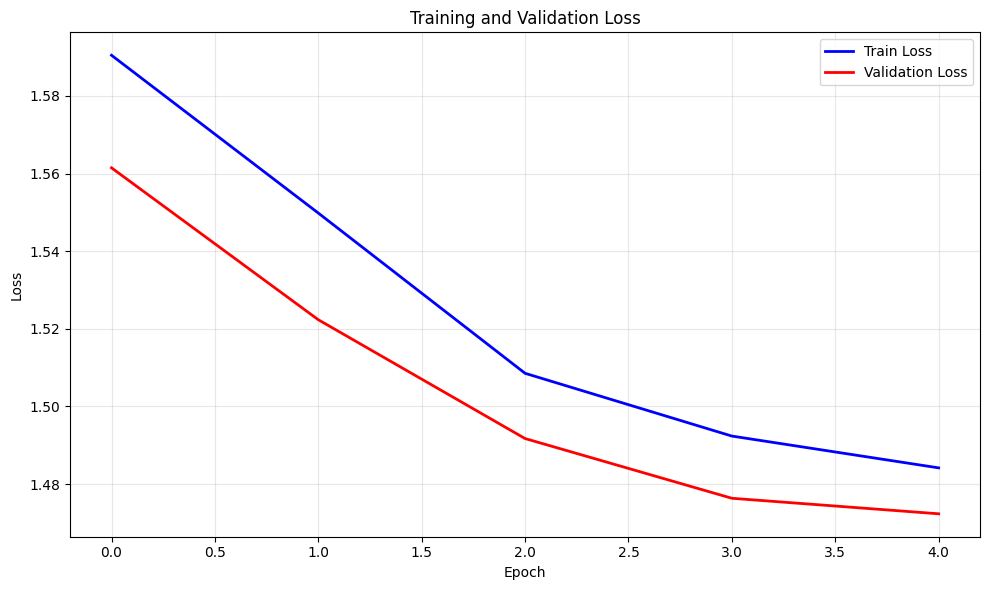

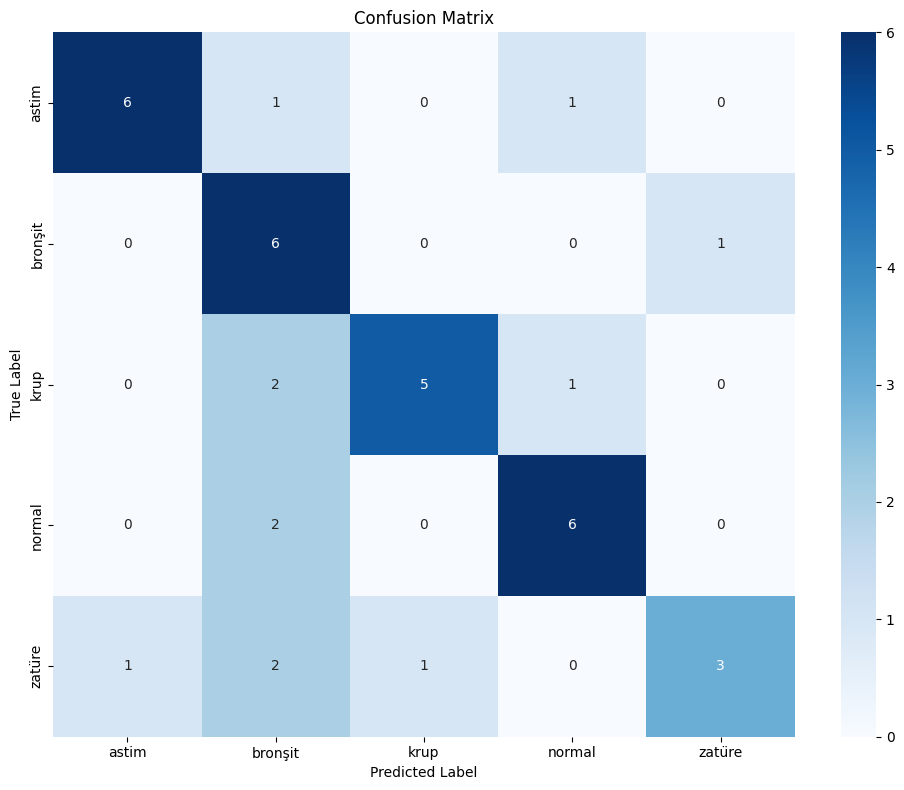

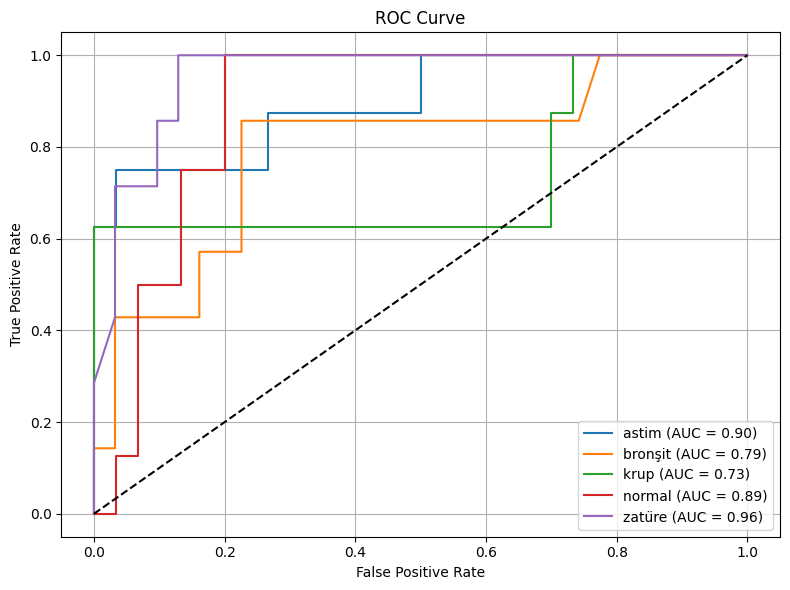

In [1]:
# =========================
# HuBERT Audio Classification - Google Colab
# =========================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import HubertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import label_binarize
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
from datetime import datetime
import zipfile
from google.colab import files, drive
import time

# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

# Training parameters
config = {
    'batch_size': 8,
    'num_epochs': 5,
    'learning_rate': 5e-5,
    'random_seed': 42,
    'freeze_hubert': True,
    'early_stopping_patience': 5
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

def load_wav(file_path, target_sr=16000, max_length=80000):
    """Load and process WAV file"""
    try:
        waveform, sr = torchaudio.load(file_path)
        if sr != target_sr:
            waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)(waveform)
        waveform = waveform.mean(dim=0)  # mono
        if waveform.shape[0] > max_length:
            waveform = waveform[:max_length]
        else:
            pad = max_length - waveform.shape[0]
            waveform = torch.nn.functional.pad(waveform, (0, pad))
        return waveform
    except Exception as e:
        print(f"Error {file_path}: {e}")
        return None

class AudioWavDataset(Dataset):
    def __init__(self, data_paths, labels):
        self.data_paths = data_paths
        self.labels = labels
    def __len__(self):
        return len(self.data_paths)
    def __getitem__(self, idx):
        wav = load_wav(self.data_paths[idx])
        label = self.labels[idx]
        return wav, label

def load_data(data_dir, class_names):
    data_paths = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    data_paths.append(file_path)
                    labels.append(class_idx)
    return data_paths, labels

class HubertWavClassifier(nn.Module):
    def __init__(self, num_classes, hidden_size=768, dropout=0.1, freeze_hubert=True):
        super().__init__()
        self.hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960")
        if freeze_hubert:
            for param in self.hubert.parameters():
                param.requires_grad = False
            print("HuBERT model frozen.")
        else:
            print("HuBERT model is trainable.")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, num_classes)
        )
    def forward(self, wav_input):
        attn_mask = (wav_input != 0).long()
        outputs = self.hubert(input_values=wav_input, attention_mask=attn_mask, return_dict=True)
        pooled = outputs.last_hidden_state.mean(dim=1)
        logits = self.classifier(pooled)
        return logits

def train_model(model, train_loader, val_loader, num_epochs, device, learning_rate=5e-5, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    best_val_acc = 0.0
    patience_counter = 0
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        try:
            model.train()
            train_loss, train_correct, train_total = 0.0, 0, 0
            for batch_idx, (wavs, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')):
                try:
                    wavs, labels = wavs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(wavs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()
                except Exception as e:
                    print(f"Training batch error: {e}")
                    continue
            train_acc = 100 * train_correct / train_total
            avg_train_loss = train_loss / len(train_loader)
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for wavs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                    try:
                        wavs, labels = wavs.to(device), labels.to(device)
                        outputs = model(wavs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()
                    except Exception as e:
                        print(f"Validation batch error: {e}")
                        continue
            val_acc = 100 * val_correct / val_total
            avg_val_loss = val_loss / len(val_loader)
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'class_names': class_names,
                    'config': config
                }, 'best_hubert_model.pth')
                print(f'  New best model saved! (Val Acc: {val_acc:.2f}%)')
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping! No improvement for {patience} epochs.')
                break
            scheduler.step()
        except Exception as e:
            print(f"Epoch {epoch+1} error: {e}")
            continue
    return train_losses, val_losses

def evaluate_model(model, test_loader, device, class_names, return_probs=False):
    model.eval()
    all_predictions, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for wavs, labels in tqdm(test_loader, desc='Testing'):
            wavs, labels = wavs.to(device), labels.to(device)
            outputs = model(wavs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    # Metrics
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names, digits=4))
    acc = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    cm = confusion_matrix(all_labels, all_predictions)
    sensitivity = recall  # Sensitivity (Recall)
    specificity = np.mean([cm[i,i]/(cm[:,i].sum() if cm[:,i].sum()>0 else 1) for i in range(len(class_names))])
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")
    # ROC and AUC
    y_true_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
    auc = roc_auc_score(y_true_bin, np.array(all_probs), average='macro', multi_class='ovr')
    print(f"AUC: {auc:.4f}")
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    # plt.show()
    # ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(all_probs)[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_score(y_true_bin[:, i], np.array(all_probs)[:, i]):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('roc_curve.png')
    # plt.show()
    if return_probs:
        return all_predictions, all_labels, all_probs
    else:
        return all_predictions, all_labels

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('training_history.png')
    # plt.show()

def mount_google_drive():
    try:
        drive.mount('/content/drive')
        print("Google Drive connected successfully!")
        return True
    except Exception as e:
        print(f"Google Drive connection error: {e}")
        return False

def load_data_from_drive():
    print("Loading data from Google Drive...")
    if not mount_google_drive():
        return False
    drive_data_path = '/content/drive/MyDrive/MakineOgrenmesiProjesi/Veri_Kumesi'
    if os.path.exists(drive_data_path):
        print(f"Data found in Drive: {drive_data_path}")
        os.system(f'cp -r "{drive_data_path}" ./data')
        print("Data copied successfully!")
        return True
    else:
        print("Could not find 'Veri_Kumesi' folder in Google Drive!")
        return False

def upload_and_extract_data():
    print("Please upload your data file (ZIP or RAR)...")
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"Uploaded file: {filename}")
        if filename.endswith('.zip'):
            print(f"Extracting {filename}...")
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall('.')
            print("ZIP extraction completed!")
            return True
        elif filename.endswith('.rar'):
            print(f"RAR file detected: {filename}")
            try:
                import rarfile
                with rarfile.RarFile(filename, 'r') as rar_ref:
                    rar_ref.extractall('.')
                print("RAR extraction completed!")
                return True
            except ImportError:
                print("Installing rarfile library...")
                os.system('pip install rarfile')
                try:
                    import rarfile
                    with rarfile.RarFile(filename, 'r') as rar_ref:
                        rar_ref.extractall('.')
                    print("RAR extraction completed!")
                    return True
                except Exception as e:
                    print(f"RAR extraction error: {e}")
                    return False
    print("No supported file format found!")
    return False

def check_data_structure():
    if os.path.exists('data'):
        print("'data' folder found!")
        for name in os.listdir('data'):
            print("Folder:", name, "| Characters:", [c for c in name])
        return True
    else:
        print("'data' folder not found!")
        return False

print("=== HUBERT AUDIO CLASSIFICATION TRAINING ===")
print("Data loading options:")
print("1. Load from Google Drive")
print("2. Upload file (ZIP/RAR)")
print("3. Manual upload")

if not check_data_structure():
    if not load_data_from_drive():
        if not upload_and_extract_data():
            print("\n" + "="*50)
            print("MANUAL DATA UPLOAD INSTRUCTIONS:")
            print("1. Extract your RAR file on your computer")
            print("2. Upload the 'data' folder to Colab")
            print("3. Run the code again")
            print("="*50)
            exit()

# --- AUTOMATIC CLASS NAME DETECTION ---
class_names = sorted([d for d in os.listdir('data') if os.path.isdir(os.path.join('data', d))])
print("Classes found:", class_names)

torch.manual_seed(config['random_seed'])
np.random.seed(config['random_seed'])

print("Loading data...")
data_paths, labels = load_data('data', class_names)

if len(data_paths) == 0:
    print("Error: No data found in data directory!")
    print("Expected directory structure:")
    for class_name in class_names:
        print(f"  data/{class_name}/*.wav")
else:
    print(f"Total {len(data_paths)} samples loaded")
    for i, class_name in enumerate(class_names):
        count = labels.count(i)
        print(f"  {class_name}: {count} samples")
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        data_paths, labels, test_size=0.3, random_state=config['random_seed'], stratify=labels
    )
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, random_state=config['random_seed'], stratify=temp_labels
    )
    print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")
    train_dataset = AudioWavDataset(train_paths, train_labels)
    val_dataset = AudioWavDataset(val_paths, val_labels)
    test_dataset = AudioWavDataset(test_paths, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0)
    print("\nCreating model...")
    model = HubertWavClassifier(
        num_classes=len(class_names),
        freeze_hubert=config['freeze_hubert']
    ).to(device)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Training time measurement
    train_start = time.time()
    train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        config['num_epochs'], device,
        config['learning_rate'],
        config['early_stopping_patience']
    )
    train_end = time.time()
    print(f"\nTraining time: {(train_end-train_start)/60:.2f} minutes")

    # Training and validation metrics (last epoch)
    print("\n--- Final Training Metrics ---")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")

    # Training and validation loss graph
    plot_training_history(train_losses, val_losses)

    # Test time and advanced metrics
    print("\nLoading best model and testing...")
    checkpoint = torch.load('best_hubert_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    inference_start = time.time()
    predictions, true_labels, y_probs = evaluate_model(model, test_loader, device, class_names, return_probs=True)
    inference_end = time.time()
    print(f"Test/Inference time: {(inference_end-inference_start):.2f} seconds")

    # Save results
    results = {
        'best_val_acc': checkpoint['val_acc'],
        'best_epoch': checkpoint['epoch'],
        'class_names': class_names,
        'config': config,
        'test_predictions': predictions,
        'test_labels': true_labels
    }
    with open('training_results.json', 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print(f"\nTraining completed!")
    print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")
    print(f"Best epoch: {checkpoint['epoch']}")
    print("\nDownloading trained model and results...")
    if os.path.exists('best_hubert_model.pth'):
        files.download('best_hubert_model.pth')
        print("Model file downloaded: best_hubert_model.pth")
    if os.path.exists('training_results.json'):
        files.download('training_results.json')
        print("Results downloaded: training_results.json")
    if os.path.exists('training_history.png'):
        files.download('training_history.png')
        print("Training graph downloaded: training_history.png")
    if os.path.exists('confusion_matrix.png'):
        files.download('confusion_matrix.png')
        print("Confusion matrix downloaded: confusion_matrix.png")
    if os.path.exists('roc_curve.png'):
        files.download('roc_curve.png')
        print("ROC curve downloaded: roc_curve.png")
    print("\nAll files downloaded successfully!")
    print("\nTo use the model:")
    print("1. Download best_hubert_model.pth file to your computer")
    print("2. Use test_model.py script to test new audio files")